# Transient analysis result example {#ref_basic_transient}

This example shows how to postprocess a transient result and visualize
the outputs.


In [1]:
# Import the necessary modules
import matplotlib.pyplot as plt
import numpy as np

from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

Download the transient result example. This example is not included in
DPF-Core by default to speed up the installation. Downloading this
example should take only a few seconds.

Next, create the model and display the state of the result. This
transient result file contains several individual results, each at a
different timestamp.


In [2]:
transient = examples.download_transient_result()
model = dpf.Model(transient)
print(model)

DPF Model
------------------------------
Static analysis
Unit system: MKS: m, kg, N, s, V, A, degC
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  reaction_force: Nodal Force   
     -  element_nodal_forces: ElementalNodal Element nodal Forces
     -  stress: ElementalNodal Stress 
     -  elemental_volume: Elemental Volume
     -  stiffness_matrix_energy: Elemental Energy-stiffness matrix
     -  artificial_hourglass_energy: Elemental Hourglass Energy
     -  thermal_dissipation_energy: Elemental thermal dissipation energy
     -  kinetic_energy: Elemental Kinetic Energy
     -  co_energy: Elemental co-energy
     -  incremental_energy: Elemental incremental energy
     -  elastic_strain: ElementalNodal Strain
     -  thermal_strain: ElementalNodal Thermal Strains
     -  thermal_strains_eqv: ElementalNodal Thermal Strains eqv
     -  swelling_strains: ElementalNodal Swelling Strains
     -  structural_temperature: ElementalNodal Temperatur

Get the timestamps for each substep as a numpy array:


In [3]:
tf = model.metadata.time_freq_support
print(tf.time_frequencies.data)

[0.         0.019975   0.039975   0.059975   0.079975   0.099975
 0.119975   0.139975   0.159975   0.179975   0.199975   0.218975
 0.238975   0.258975   0.278975   0.298975   0.318975   0.338975
 0.358975   0.378975   0.398975   0.417975   0.437975   0.457975
 0.477975   0.497975   0.517975   0.53754972 0.55725277 0.57711786
 0.59702054 0.61694639 0.63683347 0.65673452 0.67662783]


# Obtain minimum and maximum displacements for all results

Create a displacement operator and set its time scoping request to the
entire time frequency support:


In [4]:
disp = model.results.displacement()
timeids = range(1, tf.n_sets + 1)  # Must use 1-based indexing.
disp.inputs.time_scoping(timeids)

# Chain the displacement operator with ``norm`` and ``min_max`` operators.
min_max_op = ops.min_max.min_max_fc(ops.math.norm_fc(disp))

min_disp = min_max_op.outputs.field_min()
max_disp = min_max_op.outputs.field_max()
print(max_disp.data)

[0.         0.00062674 0.0025094  0.00564185 0.00999992 0.01552154
 0.02207871 0.02944459 0.03725894 0.04499722 0.05195353 0.05703912
 0.05982844 0.05897617 0.05358419 0.04310436 0.02759782 0.00798431
 0.0137951  0.03478255 0.05130461 0.05942392 0.05715204 0.04272116
 0.01787116 0.01244994 0.04062977 0.05913066 0.06042056 0.0418829
 0.01201879 0.03526532 0.05950852 0.06077103 0.03733769]


Plot the minimum and maximum displacements over time:


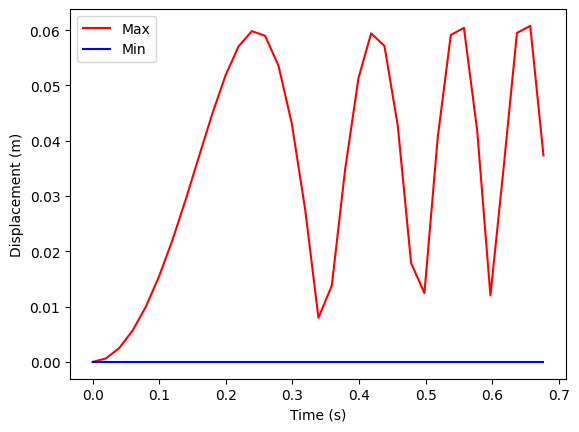

In [5]:
tdata = tf.time_frequencies.data
plt.plot(tdata, max_disp.data, "r", label="Max")
plt.plot(tdata, min_disp.data, "b", label="Min")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()

Plot the minimum and maximum displacements over time for the X
component.


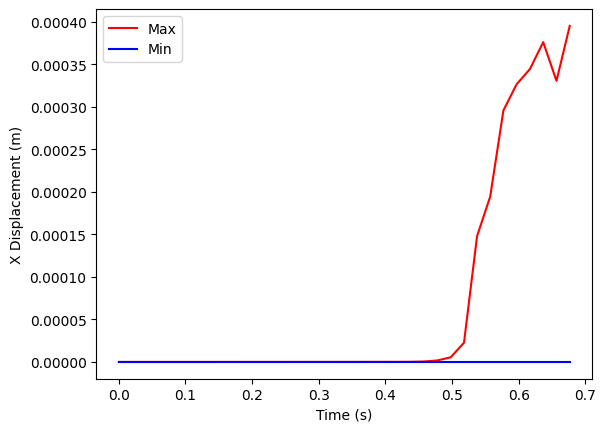

In [6]:
disp_z = disp.Z()
disp_z.inputs.time_scoping(timeids)
min_max_op = ops.min_max.min_max_fc(ops.math.norm_fc(disp_z))

min_disp_z = min_max_op.outputs.field_min()
max_disp_z = min_max_op.outputs.field_max()

tdata = tf.time_frequencies.data
plt.plot(tdata, max_disp_z.data, "r", label="Max")
plt.plot(tdata, min_disp_z.data, "b", label="Min")
plt.xlabel("Time (s)")
plt.ylabel("X Displacement (m)")
plt.legend()
plt.show()

# Postprocessing stress

Create an equivalent (von Mises) stress operator and set its time
scoping to the entire time frequency support:


In [7]:
# Component stress operator (stress)
stress = model.results.stress()

# Equivalent stress operator
eqv = stress.eqv()
eqv.inputs.time_scoping(timeids)

# Connect to the min_max operator and return the minimum and maximum
# fields.
min_max_eqv = ops.min_max.min_max_fc(eqv)
eqv_min = min_max_eqv.outputs.field_min()
eqv_max = min_max_eqv.outputs.field_max()

print(eqv_min)

DPF stress_0.s_eqv Field
  Location: Nodal
  Unit: Pa
  35 entities 
  Data:1 components and 35 elementary data 



Plot the maximum stress over time:


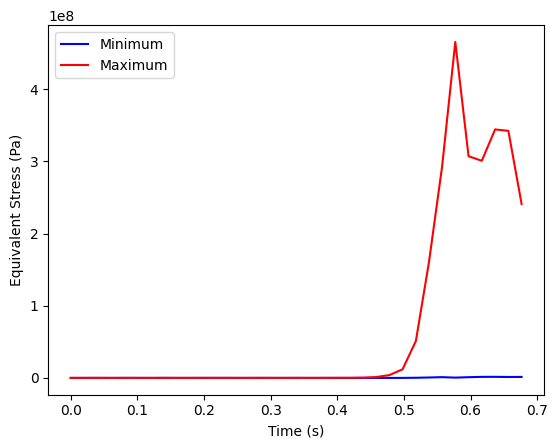

In [8]:
plt.plot(tdata, eqv_min.data, "b", label="Minimum")
plt.plot(tdata, eqv_max.data, "r", label="Maximum")
plt.xlabel("Time (s)")
plt.ylabel("Equivalent Stress (Pa)")
plt.legend()
plt.show()

# Scoping and stress field coordinates

The scoping of the stress field can be used to extract the coordinates
used for each result:


In [9]:
# Extract a single field from the equivalent stress operator.
field = eqv.outputs.fields_container()[28]

# Print the first node IDs from the field.
print(field.scoping.ids[:10])

[508 509 909 910 524 525 534 533 513 908]


As you can see, these node IDs are not in order. Additionally, there may
be fewer entries in the field than nodes in the model. For example,
stresses are not computed at mid-side nodes.

To extract the coordinates for these node IDs, load the mesh from the
model and then extract a coordinate for each node index.

Here is an inefficient way of getting the coordinates as each individual
request must be sent to the DPF service:


In [10]:
# Load the mesh from the model.
meshed_region = model.metadata.meshed_region

# Print the first 10 coordinates for the field.
node_ids = field.scoping.ids
for node_id in node_ids[:10]:
    # Fetch each individual node by node ID.
    node_coord = meshed_region.nodes.node_by_id(node_id).coordinates
    print(f"Node ID {node_id} : %8.5f, %8.5f, %8.5f" % tuple(node_coord))

Node ID 508 : -0.01251,  0.01403,  0.02310
Node ID 509 : -0.01378,  0.00218,  0.02310
Node ID 909 : -0.03000,  0.00000,  0.02310
Node ID 910 : -0.02121,  0.02121,  0.02310
Node ID 524 : -0.01251,  0.01403,  0.00000
Node ID 525 : -0.01378,  0.00218,  0.00000
Node ID 534 : -0.03000,  0.00000,  0.00000
Node ID 533 : -0.02121,  0.02121,  0.00000
Node ID 513 : -0.00891, -0.00952,  0.02310
Node ID 908 : -0.02121, -0.02121,  0.02310


Rather than individually querying for each node coordinate of the field,
you can use the
`map_scoping <ansys.dpf.core.nodes.Nodes.map_scoping>`{.interpreted-text
role="func"} to remap the field data to match the order of the nodes in
the meshed region.

Obtain the indices needed to get the data from `field.data` to match the
order of nodes in the mesh:


Scoping matches: True


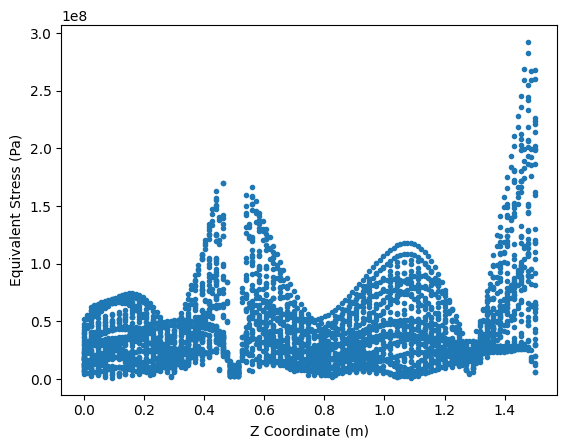

In [11]:
nodes = meshed_region.nodes
ind, mask = nodes.map_scoping(field.scoping)

# Show that the order of the remapped node scoping matches the field scoping.
print("Scoping matches:", np.allclose(np.array(nodes.scoping.ids)[ind], field.scoping.ids))

# Now plot the von Mises stress relative to the Z coordinates.
z_coord = nodes.coordinates_field.data[ind, 2]

plt.plot(z_coord, field.data, ".")
plt.xlabel("Z Coordinate (m)")
plt.ylabel("Equivalent Stress (Pa)")
plt.show()